# Natural Language Processing

So what is natural language processing? What kinds of data falls into the "natural language" bucket? What types of data are similar that you've already seen? What topics have we already discussed in the curriculum that lead up to this section?

- Pre-processing in a sense, specifically focused on preparing text for analysis/machine learning
- Sentences/conversation/dialogue - written OR spoken (audio files) - sequential
- Time series can be thought of very similarly - esp on the machine learning/NN side
- Bayesian classifiers


## Processing Text Data

Using the 'Spooky Authors' dataset: https://www.kaggle.com/c/spooky-author-identification/overview

Goal: determine whether a chunk of text was written by Edgar Allen Poe, HP Lovecraft or Mary Shelley (multi-class classification problem)

In [1]:
!ls data/

NHANES                     google-trends_taxes_us.csv
Online Retail.xlsx         ratings.csv
Wine.csv                   spooky.csv
flights.csv


In [2]:
# Wall of imports
import pandas as pd
import string
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix

First let's grab the dataset and look at a few aspects of this dataset (shape, some examples, etc). We'll be using just the train csv for this, for ease of use!

In [3]:
# Grab the train set from the competition 
df = pd.read_csv('data/spooky.csv')

In [4]:
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19579 non-null  object
 1   text    19579 non-null  object
 2   author  19579 non-null  object
dtypes: object(3)
memory usage: 459.0+ KB


In [7]:
# Exploring an example of one of the texts
df['text'][0]

'This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'

In [8]:
df['author'].value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

In [9]:
# Encoding our target from author initials to numbers
le = LabelEncoder()

df['target'] = le.fit_transform(df['author'])

In [10]:
# Checking that change
df.head()

,id,text,author,target
0,id26305,"This process, however, afforded me no means of...",EAP,0
1,id17569,It never once occurred to me that the fumbling...,HPL,1
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,0
3,id27763,How lovely is spring As we looked from Windsor...,MWS,2
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,1


In [11]:
# Grabbing our inputs and target
X = df['text']
y = df['target']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [13]:
X_train

1608     But this discovery was so great and overwhelmi...
12064    I said to myself, "This is no dream, for by wh...
16382    A robin red breast dropt from the frosty branc...
8        I knew that you could not say to yourself 'ste...
12844     Even the very lights from the city bewilder him.
                               ...                        
11284    Letting go, then, his hold upon the rod, placi...
11964    His name was John Raymond Legrasse, and he was...
5390     The manner in which Wyatt received this harmle...
860      She first assured him of her boundless confide...
15795    Thus it is abundantly clear that the gang quit...
Name: text, Length: 14684, dtype: object

In [18]:
X_train[11964]

'His name was John Raymond Legrasse, and he was by profession an Inspector of Police.'

In [14]:
# Grabbing a list of stopwords from NLTK, imported above
# We're also using the string library add punctuation to our list
stopwords_list = stopwords.words('english') + list(string.punctuation)

What is the point of a list of stopwords? How/why will we use this list?

- words that don't add any information 
- will remove these words to help de-clutter our inputs


In [17]:
stopwords_list[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

### "Bag of Words" - Count Vectorizer

Useful link to the 'User Guide' part of the documentation on this: https://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage

In [21]:
# Intstantiating our vectorizer
count_vectorizer = CountVectorizer()

# Training on the train set, then transforming the train set
X_train_count = count_vectorizer.fit_transform(X_train)
# Transforming the test set
X_test_count = count_vectorizer.transform(X_test)

In [23]:
X_train_count

<14684x22476 sparse matrix of type '<class 'numpy.int64'>'
	with 322117 stored elements in Compressed Sparse Row format>

In [24]:
# Instantiating a classifier to use on this text - Multinomial Naive Bayes
nb_classifier = MultinomialNB()

# Fitting the classifier
nb_classifier.fit(X_train_count, y_train)

# Getting our predictions for the train and test sets
train_preds = nb_classifier.predict(X_train_count)
test_preds = nb_classifier.predict(X_test_count)


0.8330949948927477


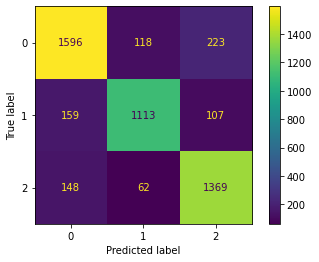

In [25]:
# Let's see how we did!
print(accuracy_score(y_test, test_preds))

plot_confusion_matrix(nb_classifier, X_test_count, y_test)

Discuss! How did we do? What could we change?

- does alright! not bad for a first pass
- didn't actually use the stopwords list!


We're about to try this on a few different vectorizers, so let's make that easier!

Here, I'm writing a function where we can provide an instantiated vectorizer, an instantiated classifer, and all of our train and test data, and the function will spit out the accuracy score and confusion matrix just like above:

In [26]:
def classify_vectorized_text(vectorizer, classifier, Xtrain, Xtest, ytrain, ytest):
    '''
    Fit and transform text data using the provided vectorizer, then fit and 
    predict with the provided classifier, in order to see the resulting
    accuracy score and confusion matrix
    For the Xtrain, Xtest, ytrain, ytest, expect the output of an
    sklearn train/test split
    -
    Inputs:
    vectorizer: an instantiated sklearn vectorizer
    classifier: an instantiated sklearn classifier
    X_train: training input data
    X_test: testing input data
    y_train: training true result
    y_test: testing true result
    -
    Outputs: 
    train_preds: predicted results for the train set
    test_preds: predicted results for the test set
    '''

    Xtrain_transformed = vectorizer.fit_transform(Xtrain)
    Xtest_transformed = vectorizer.transform(Xtest)

    classifier.fit(Xtrain_transformed, ytrain)

    train_preds = classifier.predict(Xtrain_transformed)
    test_preds = classifier.predict(Xtest_transformed)

    print(accuracy_score(ytest, test_preds))
    plot_confusion_matrix(classifier, Xtest_transformed, ytest,
                          values_format=".4g")  # to make numbers readable
    plt.show()

    return(train_preds, test_preds)

Let's add in something that was missing from our first Count Vectorizer:

Link to the documentation: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [29]:
# Instantiating a count vectorizer that removes stop words
count_stop = CountVectorizer(stop_words=stopwords_list)

Now let's create a new classifier and compare the results, using our previously-defined function!

0.8286006128702758


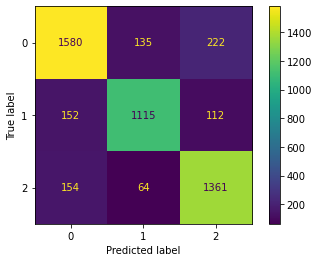

(array([1, 1, 2, ..., 0, 2, 0]), array([0, 2, 2, ..., 2, 0, 2]))

In [30]:
# Trying the same classifier, but now with stopwords removed
nb_stop = MultinomialNB()

classify_vectorized_text(count_stop, nb_stop, X_train, X_test, y_train, y_test)

Compare/discuss: 

- 


### TF-IDF: Term-Frequency - Inverse Document-Frequency

Woah, that's a term and a half. What even is it?

From [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html):

> "The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus."

Basically, it's a statistic that hopefully reflects how important a word is in the document. By looking at the overall frequency you find how common a word is across the whole corpus, compared to the document frequency that shows how common a word is within the document in question. If a word appears often in our document, but relatively rarely in the corpus, it probably captures an important word in that specific document!

In this example, the training corpus is every sentence in the `text` column in our train set, and the document is the individual sentence that we're trying to classify (per row).

Reference: http://www.tfidf.com/

We'll be using Sklearn's [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), which is 'equivalent to CountVectorizer followed by TfidfTransformer'

In [31]:
# Instantiating the TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words=stopwords_list, 
                        max_df = .95, # removes words that appear in more than 95% of docs
                        min_df = 2, # removes words that appear 2 or fewer times
                        use_idf=True)

# Training on the train set, then transforming the train set
tfidf_train = tfidf.fit_transform(X_train)
# Transforming the test set
tfidf_test = tfidf.transform(X_test)

In [32]:
# Here, number of rows is the length of our train set
tfidf_train.shape

(14684, 13556)

In [33]:
# Here, number of rows is the length of our test set
tfidf_test.shape

(4895, 13556)

We can actually explore what our vectorizer is grabbing from the test data.

In [41]:
# Let's look at a doc in our test set
X_test.iloc[22]

'Under the influence of these melancholy thoughts, she became more than ever in love with sorrow.'

In [42]:
# Creating a df of tf-idf values, where each column is a word in the vocabulary
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=tfidf.get_feature_names())

In [43]:
tfidf_test_df.head()

,aback,abandon,abandoned,abandoning,abandonment,abaout,abate,abbey,abbreviation,abdication,...,zenith,zenobia,zephyr,zest,zigzag,zigzagging,zimmer,zit,zodiacal,zokkar
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Grabbing that row once it's been vectorized
test_doc = tfidf_test_df.iloc[22]

print(test_doc.loc[test_doc > 0].sort_values(ascending=False)) # Showing values > 0

melancholy    0.427699
sorrow        0.418200
influence     0.413932
thoughts      0.387296
became        0.332006
love          0.331435
ever          0.317438
Name: 22, dtype: float64


This tells you that for the 16th document in our test set, the word 'wake' has the highest TF-IDF value.

What does this tell you about the word "wake" in the this document of our test set?

- shows up less often in other texts/documents (here, sentences) and thus might be more informative to the meaning/understanding of the sentence


In [45]:
# Let's compare to our earlier count vectorizer for this document
count_test_df = pd.DataFrame(count_stop_test.toarray(), columns=count_stop.get_feature_names())

In [47]:
count_test_doc = count_test_df.iloc[22]

print(count_test_doc.loc[count_test_doc > 0].sort_values(ascending=False)) # Showing values > 0

thoughts      1
sorrow        1
melancholy    1
love          1
influence     1
ever          1
became        1
Name: 22, dtype: int64


Easy to discuss here why using a TF-IDF Vectorizer might have some added benefits compared to a straight Count Vectorizer.

0.814708886618999


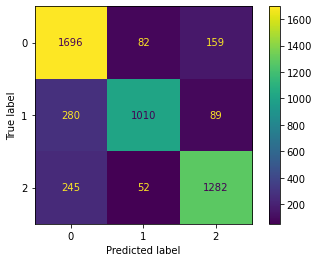

(array([0, 1, 2, ..., 0, 2, 0]), array([0, 2, 2, ..., 2, 0, 2]))

In [48]:
# Now, back to classifying: 
# Using our function to compare the results...
nb_tfidf = MultinomialNB()

classify_vectorized_text(tfidf, nb_tfidf, X_train, X_test, y_train, y_test)

Compare/discuss:

- 


0.7043922369765067


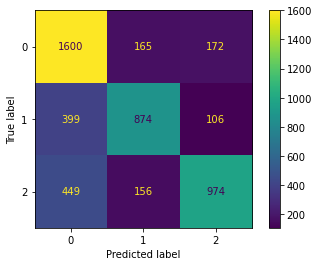

(array([2, 1, 2, ..., 0, 2, 0]), array([0, 0, 2, ..., 2, 0, 2]))

In [50]:
# We can also use our function to try different classifiers
rfc = RandomForestClassifier(n_estimators=100)

classify_vectorized_text(tfidf, rfc, X_train, X_test, y_train, y_test)

Compare/discuss: 

- 


## Additional Resources

- Sklearn's [Working with Text Data Tutorial](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

What else can we do with natural language data beyond text classification? 

- [This blog post](https://blog.aureusanalytics.com/blog/5-natural-language-processing-techniques-for-extracting-information) by Aureus Analytics provides an overview of other machine learning techniques used to extract meaning from text: Named Entity Recognition, Sentiment Analysis, Text Summarization, Aspect Mining and Topic Modeling

### Neural Network Vectorizer Resources:

Want to go beyond Count Vectorizers or TF-IDF to embed words for machine learning? Check out Word2Vec - a way of vectorizing text that tries to capture the relationships between words. See the image below, from [this paper](https://arxiv.org/pdf/1310.4546.pdf) from Google developers, that introduced a Skip-gram neural network model that's been utilized by Word2Vec (which is a tool you can use to implement this model). You'll note that the distance between each country and it's capital city is about the same - that distance actually has meaning, and thus you can imagine that the difference between `cat` and `kitten` would be the same as the difference between `dog` and `puppy`. Et cetera!

![screenshot from a paper on the Skip-gram model from devleopers at Google, https://arxiv.org/pdf/1310.4546.pdf](images/Fig2-DsitributedRepresentationsOfWordsAndPhrasesAndTheirCompositionality.png)

- [Pathmind's A.I. Wiki - A Beginner's Guide to Word2Vec](https://wiki.pathmind.com/word2vec)
- [Chris McCormick's Word2Vec Tutorial](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)